# Maintenance Contract – Cluster Monitoring & Retraining

This notebook implements a “maintenance contract” for the customer segmentation model (M0). Its goal is to monitor when the clustering model degrades over time and to define a clear retraining cadence based on both cluster stability and feature drift.

1. Simulate Cluster Drift
2. Assess Feature Stability
3. Define Maintenance Cadence

## 1. Set-up Environment and Load Data

In [1]:
# Libraries
import warnings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ks_2samp, chi2_contingency
import os
from dateutil.relativedelta import relativedelta

# Set-up environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set_theme(style="whitegrid", context="paper")
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers/')
print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers


In [3]:
# Load the data
df = pd.read_csv("./data/processed/df_maintenance.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96478 entries, 0 to 96477
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        96478 non-null  object 
 1   order_purchase_timestamp  96478 non-null  object 
 2   order_id                  96478 non-null  object 
 3   m_price                   96478 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.9+ MB


In [5]:
# Check min and max dates
min_date = df.order_purchase_timestamp.min()
max_date = df.order_purchase_timestamp.max()
print(min_date, '---', max_date)

2016-09-15 12:16:38 --- 2018-08-29 15:00:37


## 2. Functions

In [7]:
def biweekly_ari(
    df,
    features,
    best_k,
    lead_time_weeks=12,
    step_weeks=2,
    random_state=42
):
    """
    1) Define M0 end at (max_date - lead_time_weeks).
    2) Fit M0 on the prior 12 months.
    3) In bi-weekly steps, slide the end date forward by `step_weeks`:
       - Retrain Mi on the year ending at that new end date.
       - Compute ARI between M0.predict and Mi.predict on their shared customers.
    Returns a DataFrame of ARI vs. window-end.
    """
    # ensure datetime
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    max_date   = df['order_purchase_timestamp'].max()
    
    # 1) M0 end and training window
    m0_end = max_date - relativedelta(weeks=lead_time_weeks)
    m0_start = m0_end - relativedelta(years=1)
    win0 = df[(df['order_purchase_timestamp'] >= m0_start) & (df['order_purchase_timestamp'] < m0_end)]
    
    # agg features on win0
    feat0 = (
        win0
        .groupby('customer_unique_id')
        .agg(
            last_purchase = ('order_purchase_timestamp', 'max'),
            frequency     = ('order_id','nunique'),
            m_price       = ('m_price','sum')
        )
        .reset_index()
    )
    feat0['recency']     = (m0_end - feat0['last_purchase']).dt.days
    feat0['f_returning'] = (feat0['frequency'] > 1).astype(int)
    feat0['m_price_log'] = np.log1p(feat0['m_price'])
    feat0 = feat0[['customer_unique_id'] + features].set_index('customer_unique_id')
    
    # scale & fit M0
    X0  = feat0.values
    scaler0 = StandardScaler().fit(X0)
    km0     = KMeans(n_clusters=best_k, random_state=random_state).fit(scaler0.transform(X0))
    
    # prepare loop over future ends
    results = []
    n_steps = lead_time_weeks // step_weeks  # 12/2 = 6
    for i in range(1, n_steps+1):
        end_i = m0_end + relativedelta(weeks=step_weeks*i)
        start_i = end_i - relativedelta(years=1)
        win_i = df[(df['order_purchase_timestamp'] >= start_i) & (df['order_purchase_timestamp'] < end_i)]
        
        feat_i = (
            win_i
            .groupby('customer_unique_id')
            .agg(
                last_purchase = ('order_purchase_timestamp', 'max'),
                frequency     = ('order_id','nunique'),
                m_price       = ('m_price','sum')
            )
            .reset_index()
        )
        feat_i['recency']     = (end_i - feat_i['last_purchase']).dt.days
        feat_i['f_returning'] = (feat_i['frequency'] > 1).astype(int)
        feat_i['m_price_log'] = np.log1p(feat_i['m_price'])
        feat_i = feat_i[['customer_unique_id'] + features].set_index('customer_unique_id')
        
        # intersect customers
        common = feat0.index.intersection(feat_i.index)
        X0_c = feat0.loc[common].values
        Xi_c = feat_i.loc[common].values
        
        # fit Mi
        scaleri = StandardScaler().fit(Xi_c)
        km_i    = KMeans(n_clusters=best_k, random_state=random_state).fit(scaleri.transform(Xi_c))
        
        # predict & ARI
        l0 = km0.predict(scaler0.transform(X0_c))
        li = km_i.predict(scaleri.transform(Xi_c))
        ari = adjusted_rand_score(l0, li)
        
        results.append({
            'step':       i,
            'end_date':   end_i,
            'weeks_from_M0': step_weeks * i,
            'n_common':   len(common),
            'ari':        ari
        })
    
    return pd.DataFrame(results)

Matching customers in M0 and Mi: When you compute a similarity metric like the Adjusted Rand Index, you are literally comparing two partitions of the same set of objects. ARI takes two label arrays of equal length and asks “for each pair of objects, did both clusterings put them together or both keep them apart?”

In [9]:
def feature_drift_tests(
    df,
    ts_col,
    cont_features,
    bin_features,
    lead_time_weeks=12,
    step_weeks=2
):
    """
    Compute feature drift over sliding 12-month windows:
    1. Continuous features via Kolmogorov–Smirnov test
    2. Binary features via Chi-square test
    """
    # ensure datetime
    df = df.copy()
    df[ts_col] = pd.to_datetime(df[ts_col])
    max_date = df[ts_col].max()

    # Compute windowed feature table
    def window_features(end_date):
        start_date = end_date - relativedelta(years=1)
        win = df[(df[ts_col] >= start_date) & (df[ts_col] < end_date)]
        grp = win.groupby('customer_unique_id').agg(
            last_purchase=(ts_col, 'max'),
            frequency=('order_id', 'nunique'),
            m_price=('m_price', 'sum')
        ).reset_index()
        grp['recency'] = (end_date - grp['last_purchase']).dt.days
        grp['f_returning'] = (grp['frequency'] > 1).astype(int)
        grp['m_price_log'] = np.log1p(grp['m_price'])
        return grp.set_index('customer_unique_id')[[*cont_features, *bin_features]]

    # Baseline window (M0)
    m0_end = max_date - relativedelta(weeks=lead_time_weeks)
    feat0  = window_features(m0_end)

    # Store results
    ks_results  = []
    chi_results = []

    n_steps = lead_time_weeks // step_weeks
    for i in range(1, n_steps + 1):
        end_i = m0_end + relativedelta(weeks=step_weeks * i)
        feat_i = window_features(end_i)

        # Intersection of customers
        common = feat0.index.intersection(feat_i.index)
        f0 = feat0.loc[common]
        fi = feat_i.loc[common]

        # KS tests for continuous features
        for f in cont_features:
            stat, p = ks_2samp(f0[f], fi[f])
            ks_results.append({
                'feature':  f,
                'step':     i,
                'weeks':    step_weeks * i,
                'end_date': end_i,
                'ks_stat':  stat,
                'p_value':  p
            })

        # Chi-square tests for binary features
        for f in bin_features:
            # contingency table
            table = pd.DataFrame({
                'M0': f0[f].value_counts().reindex([0,1], fill_value=0),
                f'M{i}': fi[f].value_counts().reindex([0,1], fill_value=0)
            })
            chi2, p, _, _ = chi2_contingency(table)
            chi_results.append({
                'feature':   f,
                'step':      i,
                'weeks':     step_weeks * i,
                'end_date':  end_i,
                'chi2_stat': chi2,
                'p_value':   p
            })

    df_ks  = pd.DataFrame(ks_results)
    df_chi = pd.DataFrame(chi_results)
    return df_ks, df_chi

## 3. Cluster drift

The Adjusted Rand Index (ARI) is used to determine cluster drift in order to determine an appropriate maintenance cadence.

In [11]:
# ARI from Tmax - 12 weeks
df_ari_bi = biweekly_ari(
    df,
    features=['recency','f_returning','m_price_log'],
    best_k=4,
    lead_time_weeks=12,
    step_weeks=2
)
print(df_ari_bi)

   step            end_date  weeks_from_M0  n_common  ari
0     1 2018-06-20 15:00:37              2     63789 0.93
1     2 2018-07-04 15:00:37              4     62563 0.88
2     3 2018-07-18 15:00:37              6     60834 0.80
3     4 2018-08-01 15:00:37              8     59132 0.73
4     5 2018-08-15 15:00:37             10     57356 0.63
5     6 2018-08-29 15:00:37             12     55618 0.57


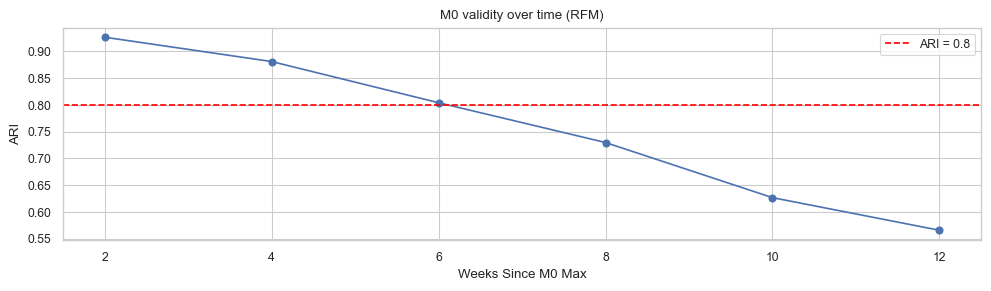

In [35]:
# Visualise ARI
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(df_ari_bi['weeks_from_M0'], df_ari_bi['ari'], marker='o', linestyle='-')
ax.axhline(0.8, color='red', linestyle='--', label=f'ARI = 0.8')
ax.set_xlabel('Weeks Since M0 Max')
ax.set_ylabel('ARI')
ax.set_title('M0 validity over time (RFM)')
ax.legend()
plt.tight_layout()
plt.savefig("./plots/maintenance/M0_ARI.png", dpi=300)
plt.show()

## 4. Feature drift
Kolmogorov–Smirnov tests are used to assess how continious features (recency and m_price_log) shift over time, and a chi-square test is used to assess binary features (f_returning) shifts over time.

In [15]:
cont_feats = ['recency', 'm_price_log']
bin_feats  = ['f_returning']
df_ks, df_chi = feature_drift_tests(
    df=df, 
    ts_col='order_purchase_timestamp',
    cont_features=cont_feats,
    bin_features=bin_feats,
    lead_time_weeks=12,
    step_weeks=2
)

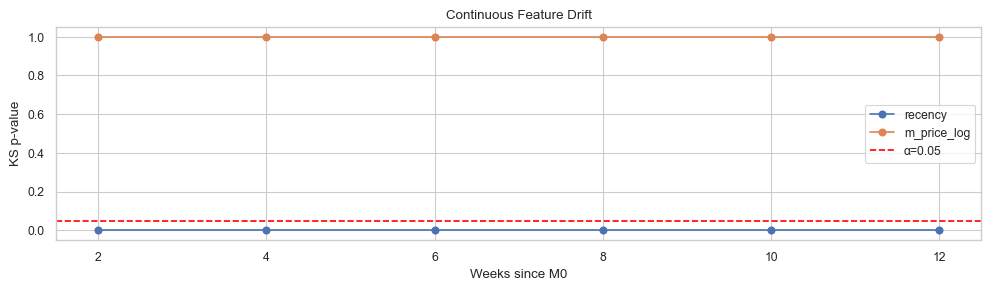

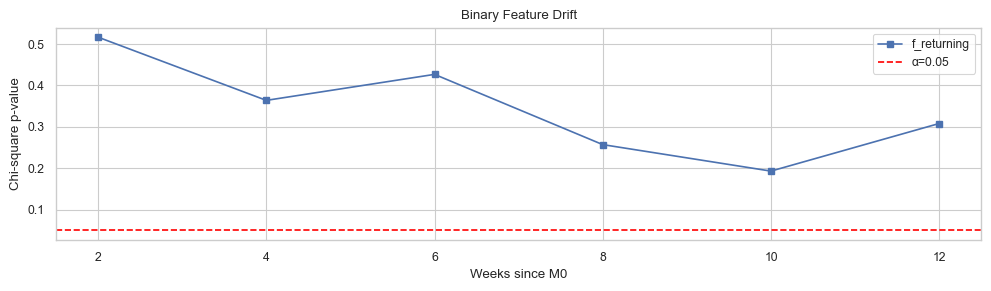

In [39]:
# Plot KS p-values
plt.figure(figsize=(10,3))
for feat in cont_feats:
    sub = df_ks[df_ks['feature']==feat]
    plt.plot(sub['weeks'], sub['p_value'], marker='o', label=feat)
plt.axhline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('Weeks since M0')
plt.ylabel('KS p-value')
plt.title('Continuous Feature Drift')
plt.legend()
plt.tight_layout()
plt.savefig("./plots/maintenance/continious_feature_drift.png", dpi=300)
plt.show()

# Plot Chi-square p-values
plt.figure(figsize=(10,3))
for feat in bin_feats:
    sub = df_chi[df_chi['feature']==feat]
    plt.plot(sub['weeks'], sub['p_value'], marker='s', label=feat)
plt.axhline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('Weeks since M0')
plt.ylabel('Chi-square p-value')
plt.title('Binary Feature Drift')
plt.legend()
plt.tight_layout()
plt.savefig("./plots/maintenance/binary_feature_drift.png", dpi=300)
plt.show()

Interpretation:
* Recency: Every week back, the “recency” distribution is completely different, which is no surprise as “recency” is “days since last order”. As such, recency will always drive some of your ARI decay.
* Price: Week 1’s price distribution is statistically the same. Changes in what people spend start to change the clusters after ~2 weeks.
* f_returning is extremely stable over time. The fraction of customers who’ve returned at least once stays essentially constant across all snapshots. It’s a “safe” feature for segmentation. Since it doesn’t drift, it won’t erode cluster definitions. No need for frequent retraining just for this flag.